In [20]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

import polars as pl

In [21]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
training_dataset = torch.load("../data/2_ready_for_training/embedded/train_dataset_large.pth")
testing_dataset = torch.load("../data/2_ready_for_training/embedded/test_dataset_large.pth")
val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_large.pth")

/tmp/ipykernel_3864/3699622598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("../data/2_ready_for_training/embedded/train_dataset_large.p

In [23]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [24]:
# Define a simple two-layer neural net with dropout and layer norm
class LargeEmbeddingNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LargeEmbeddingNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [25]:
input_dim = int(testing_dataset.X[0].shape[0])
hidden_dim = int(testing_dataset.X[0].shape[0]/2)

In [26]:
model = LargeEmbeddingNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [28]:
class FlatLRScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, schedule: list, last_epoch: int = -1):
        """
        Custom Learning Rate Scheduler.

        Args:
            optimizer (Optimizer): Wrapped optimizer.
            schedule (list): List of tuples defining (epoch_range, lr_value).
                             Example: [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
            last_epoch (int): The index of the last epoch. Default is -1.
        """
        self.schedule = []
        total_epochs = 0
        for epochs, lr in schedule:
            total_epochs += epochs
            self.schedule.append((total_epochs, lr))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        current_epoch = self.last_epoch + 1
        for end_epoch, lr in self.schedule:
            if current_epoch <= end_epoch:
                return [lr for _ in self.optimizer.param_groups]
        raise ValueError(f"Epoch {current_epoch} is out of range for the provided schedule.")

# Define the schedule: [(9 epochs at 1e-3), (8 epochs at 1e-4), (8 epochs at 1e-5)]
# schedule = [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
# schedule = [(10, 1e-3), (10, 1e-4), (5, 1e-5)]
schedule = [(15, 1e-3), (16, 1e-4)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR

# Initialize the custom scheduler
scheduler = FlatLRScheduler(optimizer, schedule)


In [29]:
criterion = nn.MSELoss()

In [30]:
num_epochs = 20

In [31]:
# Prepare data loaders
batch_size = 256
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


In [32]:
train_losses = []
test_losses = []
lr_s = []

for epoch_num in range(num_epochs):

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")


    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)
    print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")

    scheduler.step()
    current_lr = scheduler.get_last_lr()
    lr_s.append(current_lr)




TEST LOSS: PRE Epoch-0, we have 132.2175


Training Epoch 0:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-0, we have 88.9027
TEST LOSS: PRE Epoch-1, we have 78.3511


Training Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-1, we have 81.3969
TEST LOSS: PRE Epoch-2, we have 76.6913


Training Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-2, we have 67.9183
TEST LOSS: PRE Epoch-3, we have 50.0555


Training Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-3, we have 44.8884
TEST LOSS: PRE Epoch-4, we have 33.9098


Training Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-4, we have 31.3432
TEST LOSS: PRE Epoch-5, we have 23.9709


Training Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-5, we have 22.5820
TEST LOSS: PRE Epoch-6, we have 17.3168


Training Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-6, we have 16.5080
TEST LOSS: PRE Epoch-7, we have 12.5377


Training Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-7, we have 12.0309
TEST LOSS: PRE Epoch-8, we have 9.0777


Training Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-8, we have 8.9527
TEST LOSS: PRE Epoch-9, we have 6.8318


Training Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-9, we have 6.5370
TEST LOSS: PRE Epoch-10, we have 5.4700


Training Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-10, we have 5.2230
TEST LOSS: PRE Epoch-11, we have 4.7474


Training Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-11, we have 4.3304
TEST LOSS: PRE Epoch-12, we have 3.8574


Training Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-12, we have 3.9591
TEST LOSS: PRE Epoch-13, we have 4.0675


Training Epoch 13:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-13, we have 3.7527
TEST LOSS: PRE Epoch-14, we have 3.4976


Training Epoch 14:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-14, we have 3.3583
TEST LOSS: PRE Epoch-15, we have 4.0600


Training Epoch 15:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-15, we have 3.2029
TEST LOSS: PRE Epoch-16, we have 3.2587


Training Epoch 16:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-16, we have 3.0118
TEST LOSS: PRE Epoch-17, we have 3.2260


Training Epoch 17:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-17, we have 2.8688
TEST LOSS: PRE Epoch-18, we have 3.1797


Training Epoch 18:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-18, we have 2.9494
TEST LOSS: PRE Epoch-19, we have 3.1745


Training Epoch 19:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-19, we have 2.8943


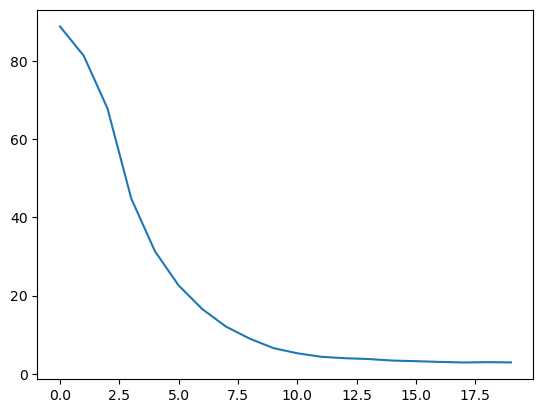

In [33]:
plt.plot(train_losses)

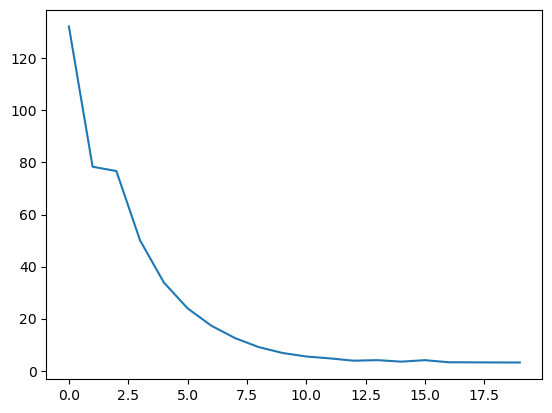

In [34]:
plt.plot(test_losses)

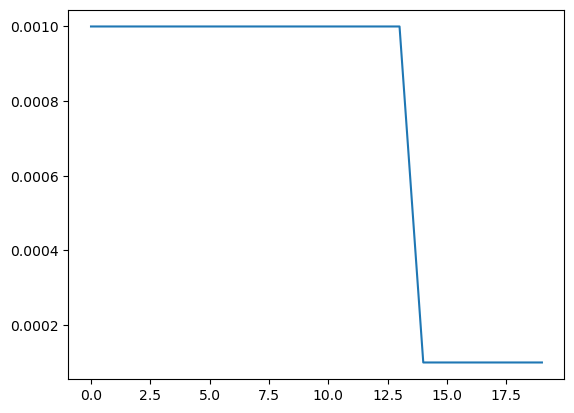

In [35]:
plt.plot(lr_s)

In [36]:
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#
# val_loss = 0.0
# model.eval()
# with torch.no_grad():
#     # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to("cuda"), labels.to("cuda")
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(-1), labels)
#         # test_loss += loss.item()
#         val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
#     avg_loss = val_loss/len(testing_dataset)
#     print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")

In [37]:
val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_large.pth")

# Assuming val_dataset is a list of (inputs, labels)
inputs_list = []
labels_list = []

for item in val_dataset:
    inputs, labels = item  # Unpack inputs and labels
    inputs_list.append(inputs.cpu().numpy())  # Convert tensors to numpy arrays
    labels_list.append(labels.cpu().numpy())

/tmp/ipykernel_3864/1025571330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_dataset = torch.load("../data/2_ready_for_training/embedded/val_dataset_large.pth")


In [38]:
labels_list_flat = [int(i) for i in labels_list]

In [39]:
# inputs_list_flat = [inp.flatten() for inp in inputs_list]  # Flatten the inputs
# labels_list_flat = [lbl.flatten() for lbl in labels_list]  # Flatten the labels

val_df = pl.DataFrame({
    # "inputs": inputs_list_flat,  # Polars will handle the flat numpy arrays
    "labels": labels_list_flat
})


In [40]:
# Assuming val_dataset, batch_size, and model are already defined
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

val_loss = 0.0
model.eval()
predictions = []  # List to store predictions in order

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(-1), labels)
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size

        # Collect predictions
        predictions.extend(outputs.squeeze(-1).cpu().tolist())

# Compute the average loss
avg_loss = val_loss / len(val_dataset)
print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")


ON VAL SET, ACHIEVED 3.8977


In [41]:
# Use the predictions to create a Polars column
val_df = val_df.with_columns(pl.Series(predictions).alias("large_embed_predictions"))
val_df.write_csv("../outputs/predictions/large_embed_predictions.csv")

In [42]:
torch.save(model.state_dict(), "../models/embedding/nn_on_large_embeddings.pth")